In [1]:
import os
import mat73
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.signal import medfilt
 
def load_proj_mat(fpath):
    return mat73.loadmat(fpath)["picdata"]
 
open_projs = load_proj_mat("D:\ct_thermometry\shared_data\OB.mat")
empty_projs1 = load_proj_mat("D:\ct_thermometry\shared_data\empty1.mat") # day 1: water
empty_projs2 = load_proj_mat("D:\ct_thermometry\shared_data\empty2.mat") # day 2: 50 mM
empty_projs3 = load_proj_mat("D:\ct_thermometry\shared_data\empty3.mat") # day 3: 600 mM, 300 mM, protein shake

# (num_projections, proj_width, proj_height)
print(open_projs.shape)
print(empty_projs1.shape)
print(empty_projs2.shape)
print(empty_projs3.shape)

[999, 999, 1000, 1000]
Average intensity in ROI of 8-33 kvp bin: 1127.908456246586
[999, 999, 1000, 1000]
Average intensity in ROI of 33-45 kvp bin: 347.9407586506548
[999, 999, 1000, 1000]
Average intensity in ROI of 45-60 kvp bin: 233.31961619348056
[999, 999, 1000, 1000]
Average intensity in ROI of 60-110 kvp bin: 291.14272831765936

[499, 499, 500, 500]
Average intensity in ROI of 8-33 kvp bin: 990.3908882247606
[499, 499, 500, 500]
Average intensity in ROI of 33-45 kvp bin: 313.9180083777812
[499, 499, 500, 500]
Average intensity in ROI of 45-60 kvp bin: 206.53374662512982
[499, 499, 500, 500]
Average intensity in ROI of 60-110 kvp bin: 258.3143181818182

[99, 99, 100, 100]
Average intensity in ROI of 8-33 kvp bin: 772.024531024531
[99, 99, 100, 100]
Average intensity in ROI of 33-45 kvp bin: 247.73079441105267
[99, 99, 100, 100]
Average intensity in ROI of 45-60 kvp bin: 164.3127471383975
[99, 99, 100, 100]
Average intensity in ROI of 60-110 kvp bin: 204.8298341968912



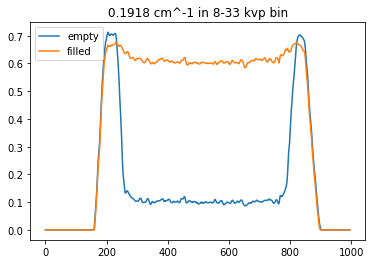

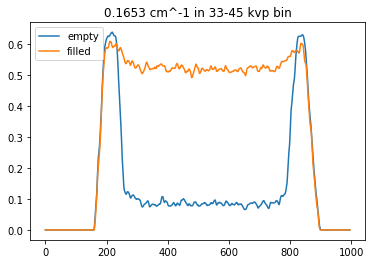

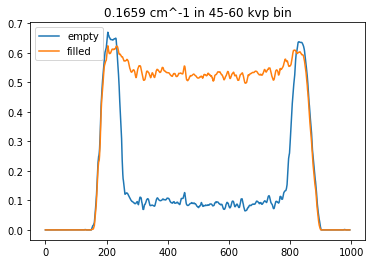

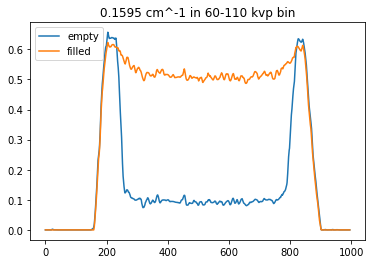

In [4]:
# SpectralScan handles calculating attenuation from projections
 
class SpectralScan():
    MAGNIFICATION = 1.23 # ratio
    INNER_DIM = 2.54 # cm
    PIXEL_DIM = 0.0055 # cm/pixel
    energies = ["8-33 kvp", "33-45 kvp", "45-60 kvp", "60-110 kvp"]
 
    def __init__(self, open_projs, empty_projs, ROI, verbose=False):
        self.r0 = ROI[0]
        self.c0 = ROI[1]
        self.r1 = ROI[2]
        self.c1 = ROI[3]
 
        self.open_projs = self.average_projections(open_projs, verbose)
        self.empty_projs = self.average_projections(empty_projs, verbose)
        self.filled_projs = None
 
    # change filled_projs attribute
    def set_filled_projs(self, filled_projs, verbose=False):
        self.filled_projs = self.average_projections(filled_projs, verbose)

    # change ROI attribute
    def set_ROI(self, ROI): 
        self.r0 = ROI[0]
        self.c0 = ROI[1]
        self.r1 = ROI[2]
        self.c1 = ROI[3]
 
    # ---------- HELPER METHODS ----------
    # sets pixels > 3 sd from the mean to NaN
    @staticmethod
    def remove_dead_pixels(proj):
        mean, stdev = np.mean(proj), np.std(proj)  
        dead_pixels = np.abs((proj-mean)/stdev) > 3
        proj = proj.astype("float")
        proj[dead_pixels] = np.NaN
        return proj
   
    # uses linear interpolation to fill in NaN values
    @staticmethod
    def interpolate_nan(proj):
        mask = np.isnan(proj)
        proj[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), proj[~mask])
        return proj
 
    # performs sliding average and median filtering on a 1D array
    @staticmethod
    def filter_profile(profile, extra=True):
        profile[profile < 0] = 0
        profile = SpectralScan.interpolate_nan(profile)
        profile = medfilt(profile, kernel_size=9)
        profile = np.convolve(np.ones(5)/5, profile, mode="valid")
 
        return profile
 
    # truncates projection to the ROI
    def get_roi(self, proj):
        return proj[self.r0:self.r1, self.c0:self.c1]
    # --------------------------------------------------
 
    # ---------- HIGH LEVEL METHODS ----------
    # stores projections averaged over the ROI for each of the 4 energy bins
    def average_projections(self, projs, verbose=False):
        width = self.r1 - self.r0
        height = self.c1 - self.c0
        averaged_projs = [np.zeros((width, height))] * 4
        proj_counts = [0] * 4
        thresholds = [2000, 800, 500, 200]
 
        num_projs = projs.shape[0]
        for i in range(num_projs):
            proj = projs[i]
            id_mean = np.mean(proj[100:200, 100:200])
            proj = SpectralScan.remove_dead_pixels(self.get_roi(proj))
 
            # add projection to others at the same energy
            for k in range(4):
                if(id_mean > thresholds[k]):
                    # NaN pixel in one projection is NaN in all projections (NaN + anything = NaN)
                    averaged_projs[k] = averaged_projs[k] + proj
                    proj_counts[k] += 1
                    break
 
        # compute averages
        for i in range(4):
            averaged_projs[i] = averaged_projs[i] / proj_counts[i]
 
        # compute bins
        for i in range(3):
            averaged_projs[i] = averaged_projs[i] - averaged_projs[i+1]
       
        if verbose:
            for i in range(4):
                proj = averaged_projs[i]
                print(proj_counts)
                print(f"Average intensity in ROI of {SpectralScan.energies[i]} bin: {str(np.nanmean(proj))}")
            print("")
 
        return averaged_projs # contains NaN values

    # calculates the attenuation in each energy bin
    def compute_attenuation(self, verbose=False, method="weak_perspective"):
        attenuations = []
 
        for i in range(4):
            empty_profile = np.log(np.divide(self.open_projs[i], self.empty_projs[i]))
            filled_profile = np.log(np.divide(self.open_projs[i], self.filled_projs[i]))
            empty_profile[empty_profile==np.inf] = np.NaN
            filled_profile[filled_profile==np.inf] = np.NaN
           
            if(method == "weak_perspective"):
                empty_profile = SpectralScan.filter_profile(empty_profile.flatten())
                filled_profile = SpectralScan.filter_profile(filled_profile.flatten())
                mu = np.sum(filled_profile - empty_profile) * SpectralScan.PIXEL_DIM / (SpectralScan.INNER_DIM**2 * SpectralScan.MAGNIFICATION)
            elif(method == "line_integral"):
                empty_profile = SpectralScan.interpolate_nan(empty_profile)
                filled_profile = SpectralScan.interpolate_nan(filled_profile)
                mu = np.nanmean(filled_profile - empty_profile) / SpectralScan.INNER_DIM      
            attenuations.append(mu)
       
            if verbose:
                plt.title(f"{mu:.4f} cm^-1 in {str(SpectralScan.energies[i])} bin")
                if(method == "weak_perspective"):
                    plt.plot(empty_profile, label="empty")
                    plt.plot(filled_profile, label="filled")
                    plt.legend()
                    plt.axis("off")
                    plt.show()
                elif(method == "line_integral"):
                    plt.hist(empty_profile.flatten(), bins=100, label="empty")
                    plt.hist(filled_profile.flatten(), bins=100, label="filled")
                    plt.xlabel("mu * x")
                    plt.ylabel("frequency")
                    plt.legend()
                    plt.show()
 
        return attenuations
    # --------------------------------------------------
 
ROI_line = [200, 200, 201, 1200]
ROI_line2 = [202, 200, 203, 1200]
ROI_rect = [100, 600, 200, 700]
 
scan = SpectralScan(open_projs, empty_projs1, ROI=ROI_line2, verbose=True)
filled_projs = load_proj_mat("D:\ct_thermometry\water_mat\T33.mat")
scan.set_filled_projs(filled_projs, verbose=True)
attenuations = scan.compute_attenuation(verbose=True, method="weak_perspective")

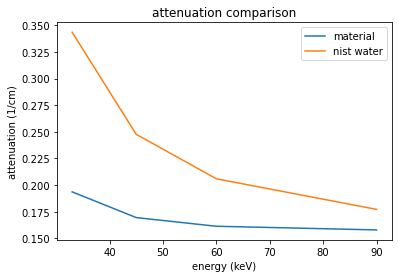

[]

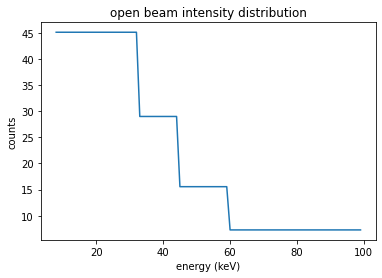

In [3]:
# compare computed attenuations to NIST values
water_nist = pd.read_excel(r"D:\\ct_thermometry\shared_data\water_attenuation_curve.xlsx")
sample_energies = [33, 45, 60, 90]
attenuations_nist = np.interp(sample_energies, water_nist["energy"]*1000, water_nist["attenuation"])
 
plt.plot(sample_energies, attenuations, label = "material")
plt.plot(sample_energies, attenuations_nist, label="nist water")
plt.title("attenuation comparison")
plt.xlabel("energy (keV)")
plt.ylabel("attenuation (1/cm)")
plt.legend()
plt.show()
 
# plot the average shape of the beam source
source_profile = []
bin_widths = [25, 12, 15, 40] # [33-8, 45-33, 60-45, 100-60]
 
for index, (proj, bin_width) in enumerate(zip(scan.open_projs, bin_widths)):
    mean_intensity = np.nanmean(proj)
    source_profile = source_profile + [mean_intensity/bin_width] * bin_width
    
plt.plot(np.arange(8, 100), source_profile)
plt.title("open beam intensity distribution")
plt.xlabel("energy (keV)")
plt.ylabel("counts")
plt.plot()

In [44]:
# generate attenuation data from mat files

# returns temperatures (array), mean attenuation (matrix), and standard deviation of attenuation (matrix)
# matrix dimensions: temperature (row), energy (column)
def get_mu_mtx(fpath, empty_projs):
    projs = [file for file in os.listdir(fpath) if file.startswith("T")]
    temperatures = [int(proj[1:3]) for proj in projs]
    mu_mtx = []
    mu_std_mtx = []
 
    for proj in projs:
        proj = load_proj_mat(os.path.join(fpath, proj))
        trials_arr = []

        # compute attenuation over several ROIs to find mean and stdev
        for i in range(10):
            scan = SpectralScan(open_projs, empty_projs, ROI=[200+i, 200, 201+i, 1200])
            scan.set_filled_projs(proj)
            trials_arr.append(scan.compute_attenuation(method="weak_perspective"))
        
        trials_arr = np.array(trials_arr)
        mu_mtx.append(np.mean(trials_arr, axis=0))
        mu_std_mtx.append(np.std(trials_arr, axis=0))
            
    return temperatures, np.array(mu_mtx), np.array(mu_std_mtx)

scan1 = SpectralScan(open_projs, empty_projs1, ROI=ROI_line) # day 1: water
scan2 = SpectralScan(open_projs, empty_projs2, ROI=ROI_line) # day 2: 50 mM
scan3 = SpectralScan(open_projs, empty_projs3, ROI=ROI_line) # day 3: 600 mM, 300 mM, protein shake

fpath_water = r"D:\\ct_thermometry\water_mat"
fpath_cacl2_50mM = r"D:\\ct_thermometry\\cacl2_50mM_mat"
fpath_cacl2_300mM = r"D:\\ct_thermometry\\cacl2_300mM_mat"
fpath_cacl2_600mM = r"D:\\ct_thermometry\\cacl2_600mM_mat"
fpath_protein_shake = r"D:\\ct_thermometry\\protein_shake_mat"

temperatures_water, mu_mtx_water, mu_std_mtx_water = get_mu_mtx(fpath_water, empty_projs1)
temperatures_cacl2_50mM, mu_mtx_cacl2_50mM, mu_std_mtx_cacl2_50mM = get_mu_mtx(fpath_cacl2_50mM, empty_projs2)
temperatures_cacl2_300mM, mu_mtx_cacl2_300mM, mu_std_mtx_cacl2_300mM = get_mu_mtx(fpath_cacl2_300mM, empty_projs3)
temperatures_cacl2_600mM, mu_mtx_cacl2_600mM, mu_std_mtx_cacl2_600mM = get_mu_mtx(fpath_cacl2_600mM, empty_projs3)
temperatures_protein_shake, mu_mtx_protein_shake, mu_std_mtx_protein_shake = get_mu_mtx(fpath_protein_shake, empty_projs3)

# ignore warnings

C:\Users\Nathan\AppData\Local\Temp\ipykernel_1444\728613711.py:107: RuntimeWarning: invalid value encountered in true_divide
  empty_profile = np.log(np.divide(self.open_projs[i], self.empty_projs[i]))
C:\Users\Nathan\AppData\Local\Temp\ipykernel_1444\728613711.py:108: RuntimeWarning: invalid value encountered in true_divide
  filled_profile = np.log(np.divide(self.open_projs[i], self.filled_projs[i]))
C:\Users\Nathan\AppData\Local\Temp\ipykernel_1444\728613711.py:108: RuntimeWarning: invalid value encountered in log
  filled_profile = np.log(np.divide(self.open_projs[i], self.filled_projs[i]))
C:\Users\Nathan\AppData\Local\Temp\ipykernel_1444\728613711.py:107: RuntimeWarning: invalid value encountered in log
  empty_profile = np.log(np.divide(self.open_projs[i], self.empty_projs[i]))


In [45]:
# save mean and standard deviation of attenuations as csv

save_path = r"D:\\ct_thermometry\\attenuation_data"
names = ["water", "cacl2_50mM", "cacl2_300mM", "cacl2_600mM", "protein_shake"]
all_temperatures = [temperatures_water, temperatures_cacl2_50mM, temperatures_cacl2_300mM, temperatures_cacl2_600mM, temperatures_protein_shake]
all_mu_mtx = [mu_mtx_water, mu_mtx_cacl2_50mM, mu_mtx_cacl2_300mM, mu_mtx_cacl2_600mM, mu_mtx_protein_shake]
all_mu_std_mtx = [mu_std_mtx_water, mu_std_mtx_cacl2_50mM, mu_std_mtx_cacl2_300mM, mu_std_mtx_cacl2_600mM, mu_std_mtx_protein_shake]

for i in range(5):
    name = names[i]
    temperatures = pd.DataFrame(all_temperatures[i])
    mu_mtx = pd.DataFrame(all_mu_mtx[i])
    mu_std_mtx = pd.DataFrame(all_mu_std_mtx[i])
    
    temperatures.to_csv(f"{save_path}\\temperatures_{name}.csv", header=None, index=None)
    mu_mtx.to_csv(f"{save_path}\mu_mtx_{name}.csv", header=None, index=None)
    mu_std_mtx.to_csv(f"{save_path}\mu_std_mtx_{name}.csv", header=None, index=None)

In [3]:
# load data from csv

def read_csv(fname):
    return pd.read_csv(f"D:\ct_thermometry\\attenuation_data\{fname}.csv", header=None).to_numpy()

temperatures_water = read_csv("temperatures_water", ).flatten()
temperatures_cacl2_50mM = read_csv("temperatures_cacl2_50mM").flatten()
temperatures_cacl2_300mM = read_csv("temperatures_cacl2_300mM").flatten()
temperatures_cacl2_600mM = read_csv("temperatures_cacl2_600mM").flatten()
temperatures_protein_shake = read_csv("temperatures_protein_shake").flatten()

mu_mtx_water = read_csv("mu_mtx_water")
mu_mtx_cacl2_50mM = read_csv("mu_mtx_cacl2_50mM")
mu_mtx_cacl2_300mM = read_csv("mu_mtx_cacl2_300mM")
mu_mtx_cacl2_600mM = read_csv("mu_mtx_cacl2_600mM")
mu_mtx_protein_shake = read_csv("mu_mtx_protein_shake")

mu_std_mtx_water = read_csv("mu_std_mtx_water")
mu_std_mtx_cacl2_50mM = read_csv("mu_std_mtx_cacl2_50mM")
mu_std_mtx_cacl2_300mM = read_csv("mu_std_mtx_cacl2_300mM")
mu_std_mtx_cacl2_600mM = read_csv("mu_std_mtx_cacl2_600mM")
mu_std_mtx_protein_shake = read_csv("mu_std_mtx_protein_shake")

In [24]:
def read_from_csv(fname):
    data = pd.read_csv(f"attenuation_data\{fname}", header=None).to_numpy()

    if(fname[0] == "t"):
        return data.flatten()
    return data

prefixes = ["mu_", "std_", "temp_"]
mixtures = ["c300", "c50", "c600", "protein", "water"]
keys = [prefix + mix for prefix in prefixes for mix in mixtures]
values = os.listdir("attenuation_data")
data_dict = {}

for key, value in zip(keys, values):
    data_dict[key] = read_from_csv(value)

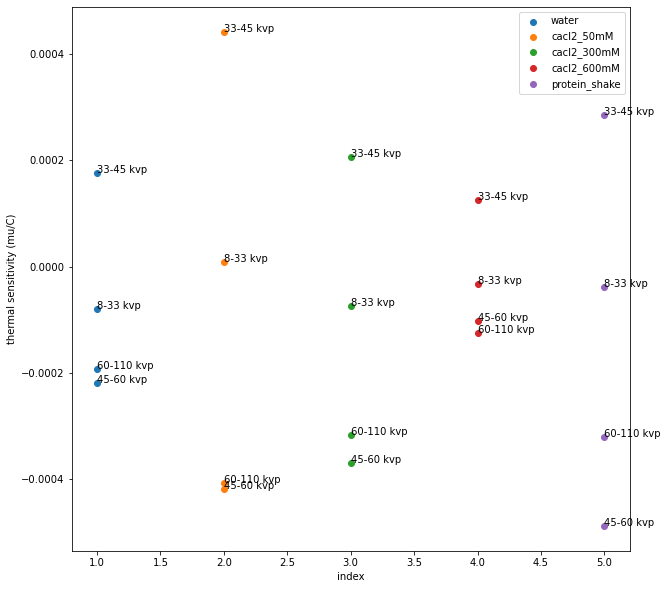

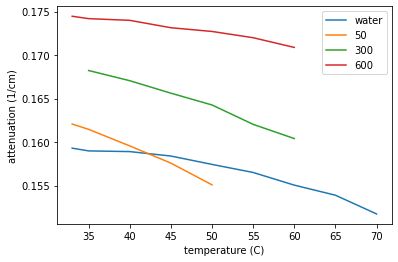

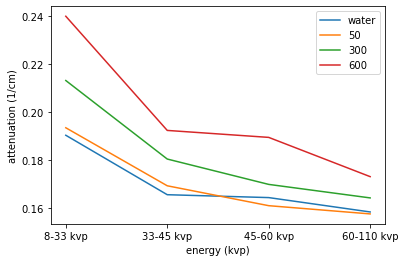

[array([[0, 1, 2],
        [0, 1, 2],
        [0, 1, 2]]),
 array([[0, 0, 0],
        [1, 1, 1],
        [2, 2, 2]])]

In [4]:
# data visualizations

water_alpha = np.polyfit(temperatures_water, mu_mtx_water, 1)[0]
cacl2_50mM_alpha = np.polyfit(temperatures_cacl2_50mM, mu_mtx_cacl2_50mM, 1)[0]
cacl2_300mM_alpha = np.polyfit(temperatures_cacl2_300mM, mu_mtx_cacl2_300mM, 1)[0]
cacl2_600mM_alpha = np.polyfit(temperatures_cacl2_600mM, mu_mtx_cacl2_600mM, 1)[0]
protein_shake_alpha = np.polyfit(temperatures_protein_shake, mu_mtx_protein_shake, 1)[0]
all_slopes = [water_alpha, cacl2_50mM_alpha, cacl2_300mM_alpha, cacl2_600mM_alpha, protein_shake_alpha]
legend = ["water", "cacl2_50mM", "cacl2_300mM", "cacl2_600mM", "protein_shake"]

# plot energy-specific thermal sensitivities for each material
plt.figure(figsize=(10,10))
for i, material in enumerate(all_slopes): 
    plt.scatter((i+1)*np.ones(4), material, label = legend[i])

    for k, label in enumerate(SpectralScan.energies):
        plt.annotate(label, (i+1, material[k]))

# plt.ylim(top=0.0004)
plt.legend()
plt.xlabel("index")
plt.ylabel("thermal sensitivity (mu/C)")
plt.show()

# plot attenuation vs. temperature for a given energy channel
channel = 3
plt.plot(temperatures_water, mu_mtx_water[:,channel], label="water")
plt.plot(temperatures_cacl2_50mM, mu_mtx_cacl2_50mM[:,channel], label="50")
plt.plot(temperatures_cacl2_300mM, mu_mtx_cacl2_300mM[:,channel], label="300")
plt.plot(temperatures_cacl2_600mM, mu_mtx_cacl2_600mM[:,channel], label="600")
plt.xlabel("temperature (C)")
plt.ylabel("attenuation (1/cm)")
plt.legend()
plt.show()

# plot attenuation vs. energy for a given temperature
temp = 3
plt.plot(SpectralScan.energies, mu_mtx_water[temp,:], label="water")
plt.plot(SpectralScan.energies, mu_mtx_cacl2_50mM[temp,:], label="50")
plt.plot(SpectralScan.energies, mu_mtx_cacl2_300mM[temp,:], label="300")
plt.plot(SpectralScan.energies, mu_mtx_cacl2_600mM[temp,:], label="600")
plt.xlabel("energy (kvp)")
plt.ylabel("attenuation (1/cm)")
plt.legend()
plt.show()


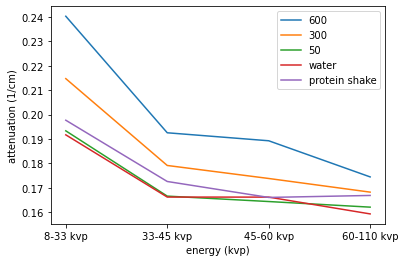

In [7]:
temp = 0 
plt.plot(SpectralScan.energies, mu_mtx_cacl2_600mM[temp,:], label="600")
plt.plot(SpectralScan.energies, mu_mtx_cacl2_300mM[temp,:], label="300")
plt.plot(SpectralScan.energies, mu_mtx_cacl2_50mM[temp,:], label="50")
plt.plot(SpectralScan.energies, mu_mtx_water[temp,:], label="water")
plt.plot(SpectralScan.energies, mu_mtx_protein_shake[temp,:], label="protein shake")
plt.xlabel("energy (kvp)")
plt.ylabel("attenuation (1/cm)")
plt.legend()
plt.show()

In [6]:
# using one-step algorithm described in https://arxiv.org/abs/2202.13297

class TemperaturePrediction():
    def __init__(self, basis1_mu, basis2_mu, basis1_alpha, basis2_alpha):
        # all of these should be column vectors
        self.basis1_mu = basis1_mu
        self.basis2_mu = basis2_mu
        self.basis1_alpha = basis1_alpha
        self.basis2_alpha = basis2_alpha
        self.attenuations = None
 
    def simulate_attenuations(self, v1, v2, delta_t):
        mu = v1*(self.basis1_mu + delta_t*self.basis1_alpha) + v2*(self.basis2_mu + delta_t*self.basis2_alpha)
        return mu
 
    def predict_temperature(self, attenuations):
        mtx_cols = [self.basis1_mu, self.basis2_mu, self.basis1_alpha, self.basis2_alpha]
 
        # check that all are column vectors
        for col in mtx_cols:
            assert(col.shape[1] == 1)
 
        mtx = np.concatenate(mtx_cols, axis=1)
        row_4 = np.array([[1, 1, 0, 0]]) # v1 + v2 = 1
        mtx = np.concatenate([mtx, row_4], axis=0)
        mtx = np.delete(mtx, 1, 0) # delete row 1 which corresponds to 33-45 kvp bin
        inverse = np.linalg.inv(mtx)
 
        print(attenuations)
        print("")
        print(mtx)
        print("")
 
        result = np.matmul(inverse, attenuations)
        return result
 
water_cacl2_temp_predictor = TemperaturePrediction(
    np.expand_dims(mu_mtx_water[0,:], axis=1), # at 33 C
    np.expand_dims(mu_mtx_cacl2_300mM[0,:], axis=1),
    np.expand_dims(water_alpha, axis=1),
    np.expand_dims(cacl2_300mM_alpha, axis=1),
)
 
# thermal sensitivity as a weighted average is not a good assumption
for i in range(5):
    mu = np.reshape(mu_mtx_cacl2_50mM[i,:], (4,1)) # read in attenuation at each temperature
    mu = np.delete(mu, 1, 0) # delete row 1 which corresponds to 33-45 kvp bin
    mu = np.concatenate([mu, np.array([[1]])], axis=0)

    pred = water_cacl2_temp_predictor.predict_temperature(mu)
    print(f"v1 = {pred[0]}")
    print(f"v2 = {pred[1]}")
    print(f"t1 = {pred[2] / pred[0] + 33}")
    print(f"t2 = {pred[3] / pred[1] + 33}")
    print(f"t = {temperatures_cacl2_300mM[i]}")
    print("--------------------")

[[0.19332263]
 [0.16437266]
 [0.16207452]
 [1.        ]]

[[ 1.91683404e-01  2.14698337e-01 -7.95597700e-05 -7.43957219e-05]
 [ 1.66183233e-01  1.73811896e-01 -2.19929670e-04 -3.70207475e-04]
 [ 1.59302681e-01  1.68221780e-01 -1.92754431e-04 -3.16992171e-04]
 [ 1.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00]]

v1 = [14.16659223]
v2 = [-13.16659223]
t1 = [-535.5798646]
t2 = [-310.19612079]
t = 35
--------------------
[[0.19348521]
 [0.16421945]
 [0.16146374]
 [1.        ]]

[[ 1.91683404e-01  2.14698337e-01 -7.95597700e-05 -7.43957219e-05]
 [ 1.66183233e-01  1.73811896e-01 -2.19929670e-04 -3.70207475e-04]
 [ 1.59302681e-01  1.68221780e-01 -1.92754431e-04 -3.16992171e-04]
 [ 1.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00]]

v1 = [12.53687742]
v2 = [-11.53687742]
t1 = [-530.96167505]
t2 = [-310.92705735]
t = 40
--------------------
[[0.19337278]
 [0.16283954]
 [0.15956046]
 [1.        ]]

[[ 1.91683404e-01  2.14698337e-01 -7.95597700e-05 -7.43957219e-05]
 [

In [7]:
# generate training examples for MLP regression

def generate_example(mu_mtx, mu_std_mtx, temperatures):
    rand_index = np.random.randint(low=0, high=mu_mtx.shape[0])
    mu_randtemp = mu_mtx[rand_index, :]
    mu_std = mu_std_mtx[rand_index, :] 

    mu_temp33 = mu_mtx[0,:] # attenuations at 33 C
    rand_noise = np.random.normal(np.zeros(4), mu_std, 4)
    delta = (mu_randtemp + rand_noise - mutemp33) _* 100
    input_vec = np.concatenate([mu_randtemp, delta], axis=0)

    return input_vec, temperatures[rand_index]

X_set = []
y_set = []
num = 333

for i in range(num):
    x1, y1 = generate_example(mu_mtx_water, mu_std_mtx_water, temperatures_water)
    x2, y2 = generate_example(mu_mtx_cacl2_600mM, mu_std_mtx_cacl2_600mM, temperatures_cacl2_600mM)
    x3, y3 = generate_example(mu_mtx_cacl2_50mM, mu_std_mtx_cacl2_50mM, temperatures_cacl2_50mM)

    X_set = X_set + [x1, x2, x3]
    y_set = y_set + [y1, y2, y3]

X_set = np.reshape(np.array(X_set), (3*num, 1, 8))
y_set = np.reshape(np.array(y_set), (3*num, 1, 1))

# (training_examples, 1, elements)
print(X_set.shape)
print(y_set.shape)

(999, 1, 8)
(999, 1, 1)


In [19]:
# define model
class TemperatureMLP(tf.keras.Model):
    def __init__(self, activation):
        super().__init__()
        self.layer1 = tf.keras.layers.Dense(4, activation=activation)
        self.layer2 = tf.keras.layers.Dense(4, activation=activation)
        self.temperature = tf.keras.layers.Dense(1, activation=activation)

    def call(self, inputs):
        x = self.layer1(inputs)
        x = self.layer2(x)
        x = self.temperature(x)
        
        return x

    def model(self):
        inputs = tf.keras.Input(shape=(1,8))
        return tf.keras.Model(inputs=[inputs], outputs=self.call(inputs))

temp_mlp = TemperatureMLP(activation="relu")
temp_mlp.model().summary()
opt = tf.keras.optimizers.SGD(learning_rate=1e-5)
temp_mlp.compile(
    optimizer = opt,
    loss = "mse",
    metrics = ["mae"]
)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 8)]            0         
_________________________________________________________________
dense (Dense)                (None, 1, 4)              36        
_________________________________________________________________
dense_1 (Dense)              (None, 1, 4)              20        
_________________________________________________________________
dense_2 (Dense)              (None, 1, 1)              5         
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
799/799 [==============================] - 2s 2ms/step - loss: 2098.5913 - mae: 44.6810 - val_loss: 1962.5161 - val_mae: 43.1275

Epoch 00001: val_mae improved from inf to 43.12754, saving model to D:\\ct_thermometry\MLP-01-43.13.tf
INFO:tensorflow:Assets written to: D:\\ct_thermometry\MLP-01-43.13.tf\assets
Epoch 2/100
799/799 [==============================] - 1s 1ms/step - loss: 1792.8268 - mae: 41.0968 - val_loss: 1220.6163 - val_mae: 33.6683

Epoch 00002: val_mae improved from 43.12754 to 33.66830, saving model to D:\\ct_thermometry\MLP-02-33.67.tf
INFO:tensorflow:Assets written to: D:\\ct_thermometry\MLP-02-33.67.tf\assets
Epoch 3/100
799/799 [==============================] - 1s 2ms/step - loss: 328.2757 - mae: 14.1071 - val_loss: 42.0363 - val_mae: 5.9062

Epoch 00003: val_mae improved from 33.66830 to 5.90615, saving model to D:\\ct_thermometry\MLP-03-5.91.tf
INFO:tensorflow:Assets written to: D:\\ct_thermometry\MLP-03-5.91.tf\assets
Epoch 4/100
799/799 [==========

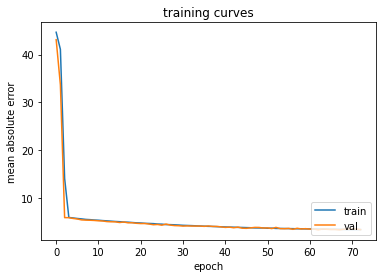

In [18]:
# train the MLP regression model

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = r"D:\\ct_thermometry\\MLP-{epoch:02d}-{val_mae:.2f}.tf",
    monitor = "val_mae",
    verbose = 1,
    save_best_only = True,
    mode = "min"
)
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=10, verbose=1) # stops training after "patience" epochs with no increase in val_accuracy
log_csv = tf.keras.callbacks.CSVLogger("D:\ct_thermometry\\shared_data\\training_logs.csv", separator=",", append=False) # save data for training curves

history = temp_mlp.fit(
    X_set,
    y_set, 
    batch_size = 1,
    shuffle = True,
    epochs = 100, 
    validation_split = 0.2,
    callbacks = [early_stop, log_csv, checkpoint]
)

plt.plot(history.history["mae"], label="train")
plt.plot(history.history["val_mae"], label="validation")
plt.title("training curves")
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [20]:
# load trained model
# must instantiate subclassed model before loading weights to use model(input) to predict
# cryptic error messages when run twice

loaded_model = TemperatureMLP(activation="relu")
loaded_model.load_weights("MLP-63-3.34.tf")

protein_shake
prediction: 35.92 C, label: 38 C
prediction: 38.17 C, label: 40 C
prediction: 40.40 C, label: 43 C
prediction: 42.67 C, label: 45 C
prediction: 50.16 C, label: 50 C

cacl2_300mM
prediction: 36.35 C, label: 35 C
prediction: 41.95 C, label: 40 C
prediction: 48.04 C, label: 45 C
prediction: 54.23 C, label: 50 C
prediction: 60.75 C, label: 55 C
prediction: 67.48 C, label: 60 C



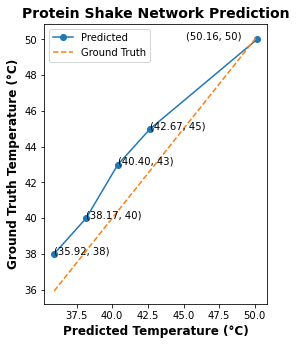

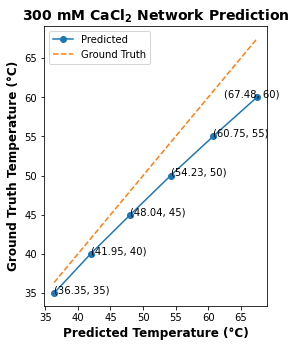

In [71]:
def predict_on_material(mu_mtx, temperatures, verbose=False):
    predictions = []
    temp33 = mu_mtx[0,:] 

    for i in range(len(temperatures)):
        input_vec = np.reshape(mu_mtx[i, :], (1,4))
        delta = (input_vec - temp33) * 100
        network_inp = np.concatenate([input_vec, delta], axis=1)

        pred = loaded_model(network_inp).numpy()[0][0]
        predictions.append(pred)

        if verbose:
            print(f"prediction: {pred:.2f} C, label: {temperatures[i]} C")
    print("")

    return predictions

print("protein_shake")
rv1 = predict_on_material(data_dict["mu_protein"], data_dict["temp_protein"], verbose=True)

print("cacl2_300mM")
rv2 = predict_on_material(data_dict["mu_c300"], data_dict["temp_c300"], verbose=True)

plt.figure(figsize=(4,5.15))
plt.plot(rv1, data_dict["temp_protein"], "-o", label="Predicted")
plt.plot(rv1, rv1, linestyle="dashed", label="Ground Truth")
plt.xlabel("Predicted Temperature (°C)", fontweight="bold", fontsize=12)
plt.ylabel("Ground Truth Temperature (°C)", fontweight="bold", fontsize=12)
plt.title("Protein Shake Network Prediction", fontweight="bold", fontsize=14)

for i in range(4):
    label = data_dict["temp_protein"][i]
    plt.annotate(f"({rv1[i]:.2f}, {label})", (rv1[i], data_dict["temp_protein"][i]))

label = data_dict["temp_protein"][4]
plt.annotate(f"({rv1[4]:.2f}, {label})", (rv1[4]-5, label))

plt.legend()
plt.show()


plt.figure(figsize=(4,5.15))
plt.plot(rv2, data_dict["temp_c300"], "-o", label="Predicted")
plt.plot(rv2, rv2, linestyle="dashed", label="Ground Truth")
plt.xlabel("Predicted Temperature (°C)", fontweight="bold", fontsize=12)
plt.ylabel("Ground Truth Temperature (°C)", fontweight="bold", fontsize=12)
plt.title("300 mM $\mathregular{CaCl_2}$ Network Prediction", fontweight="bold", fontsize=14)

for i in range(5):
    label = data_dict["temp_c300"][i]
    plt.annotate(f"({rv2[i]:.2f}, {label})", (rv2[i], data_dict["temp_c300"][i]))

label = data_dict["temp_c300"][5]
plt.annotate(f"({rv2[5]:.2f}, {label})", (rv2[5]-5, label))

plt.legend()
plt.show()
